### non-time-series validation
* train/test 2-8 split with random sampling
* cross validation

In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *
%aimport model_manage
from model_manage import *

import logging
from utils import *
set_logger(logging.DEBUG)

In [2]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

In [3]:
import logging
set_logger(logging.DEBUG)

In [4]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
#ds.update_views()

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']


In [5]:
df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
print(df_transaction.shape)
print(df_property.shape)

(1512560, 23)
(709325, 20)


In [6]:
pp = Preprocess(df_transaction, df_property)

In [7]:
pp.get_feature_list()

['date',
 'sqft',
 'num_bed',
 'num_bath',
 'view',
 'pool',
 'sqft_zip_avg',
 'sqft_price_zip_avg',
 'sold_price_zip_avg',
 'impr_over_land',
 'lon',
 'lat']

In [14]:
# records of last year
use_features = ['sqft', 'num_bed', 'num_bath', 'view', 'pool', 'sqft_zip_avg', 'sqft_price_zip_avg', 'sold_price_zip_avg', 'impr_over_land']
df_last_year_valid = pp.dataset(feature_set=use_features, valid=True, date=('2016-10-01', '2017-10-01'))
df_last_year_valid.shape

[dp] transforming date
[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


(37638, 10)

In [16]:
df_last_year_valid.head()

,sqft_price_zip_avg,sold_price_zip_avg,num_bed,sqft_zip_avg,pool,view,num_bath,sold_price,sqft,impr_over_land
1,263.526802,404081.330869,4.0,1575.903882,0,0,2.0,402000,1447,1.512500
6373,406.269598,524327.915870,3.0,1338.047801,0,0,2.0,668000,1427,0.483556
6374,406.269598,524327.915870,4.0,1338.047801,0,1,2.0,800000,1710,0.479241
6375,406.269598,524327.915870,2.0,1338.047801,0,0,1.0,432500,1084,0.453742
29902,274.577947,479142.585551,5.0,1829.785171,0,0,3.0,512000,2112,0.651613


### LinearRegression

In [22]:
from sklearn.linear_model import Ridge
rr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', ElasticNet(random_state=42))
     ])
parameters = {'clf__l1_ratio': [0.05, 0.07, 0.1, 0.12, 0.14],
              'clf__alpha': [0.01, 0.03, 0.05, 0.07, 0.09]}

mm = ModelManager(df_last_year_valid, use_features, rr)
mm.run(param_grid=parameters, GridSearchCV={'cv':3, 'verbose':True, 'n_jobs':-1})

[dp] train/valid/test size: 24088, 6022, 7528
[dp] 3-fold cross validation: train/valid size 10036


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    9.1s finished


177210.31291874146

In [23]:
mm.summary()

[dp] best params: {'clf__alpha': 0.01, 'clf__l1_ratio': 0.14}
[dp] best score: -30054511907.963722
[dp] cv results:
{'mean_fit_time': array([0.16928331, 0.50985575, 0.44134132, 0.47375933, 0.4724226 ,
       0.29478447, 0.27222395, 0.29762419, 0.27623407, 0.31400077,
       0.19217817, 0.27773849, 0.36446953, 0.29378072, 0.20571438,
       0.18432395, 0.19568594, 0.2301116 , 0.1975259 , 0.17529925,
       0.20220359, 0.25116762, 0.22108841, 0.18515984, 0.10377494]),
 'mean_score_time': array([0.00217255, 0.0031755 , 0.00284028, 0.003009  , 0.00267506,
       0.00300813, 0.00317597, 0.00317605, 0.00351016, 0.00367777,
       0.00300813, 0.00300797, 0.00300829, 0.00284147, 0.00317502,
       0.00584841, 0.00301003, 0.00300829, 0.00284084, 0.00267418,
       0.0031755 , 0.0028429 , 0.002841  , 0.00300837, 0.00284139]),
 'mean_test_score': array([-3.00599410e+10, -3.00587162e+10, -3.00568982e+10, -3.00556996e+10,
       -3.00545119e+10, -3.02053367e+10, -3.02000888e+10, -3.01922848e+10,
  

[dp] training error: 172340.3011158606
[dp] testing error: 177210.31291874146


In [24]:
mm.plot_feature_importance()

[dp] StandardScaler->ElasticNet has no feature_importances_


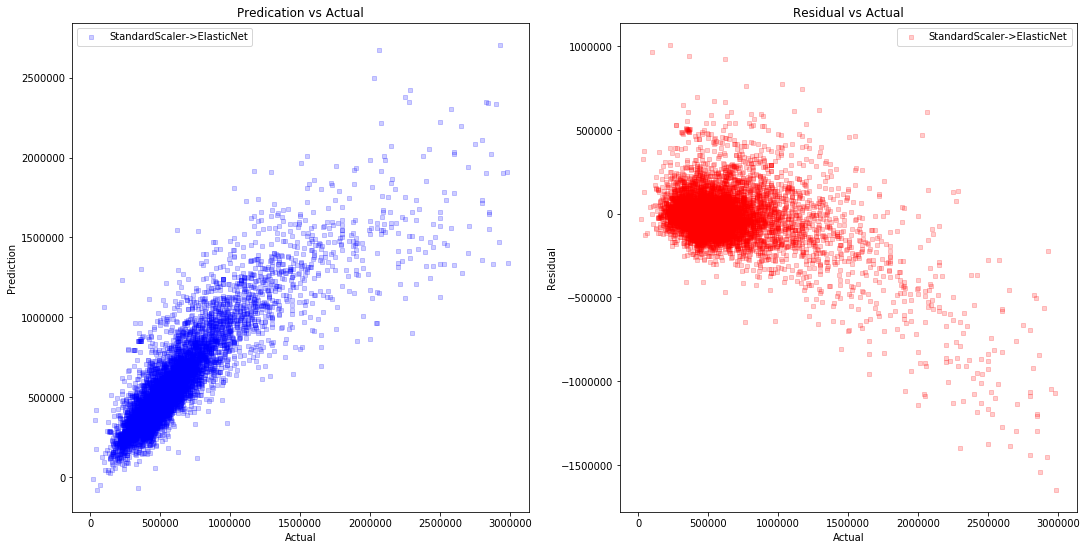

In [25]:
mm.plot_residual()

## Random Forest Model

10-fold cross-validation to select the best number of trees and depth of each tree in the forest.

In [ ]:
ntrees = np.arange(20,130,40)
depths = np.arange(7,15)
parameters = { 'n_estimators': ntrees, 'max_depth': depths}
rf = RandomForestRegressor(n_jobs=-1, random_state=17)

mm = ModelManager(df_last_year_valid, use_features, rf)
mm.run(param_grid=parameters, GridSearchCV={'cv':3, 'verbose':True, 'n_jobs':-1})
mm.run()

In [20]:
mm.summary()

[dp] best params: {'n_estimators': 140, 'max_depth': 18}
[dp] best score: 0.8602005877710411
[dp] cv results:
{'mean_fit_time': array([  0.35458565,   1.909506  ,   2.75480302,   3.90698576,
         5.309992  ,   1.14793372,   1.64587339,   3.14186414,
         4.8062257 ,   6.28144177,   1.24687568,   2.31248967,
         3.94186982,   6.32369757,   9.1647102 ,   1.62962508,
         2.43967183,   5.26921709,   7.2770892 ,   7.93150179,
         1.75684794,   3.67606219,   5.21529325,   7.38261048,
         9.24773614,   1.49899824,   2.94477312,   5.22472596,
         7.88555209,   9.83041112,   2.05231516,   3.89369257,
         7.13470324,   9.28548853,  10.83536585,   1.85526888,
         3.6336364 ,   6.62384613,  10.00864283,  13.89781968,
         2.88014706,   5.0868663 ,   8.45212841,  11.75663495,
        13.60809739,   2.37845739,   4.76207161,   8.50317097,
        13.38799842,  15.09807261,   2.6744628 ,   6.34367768,
         9.91717625,  13.30153378,  16.36891143,   2.

[dp] training error: 57952.366967712325
[dp] testing error: 135929.17307717196


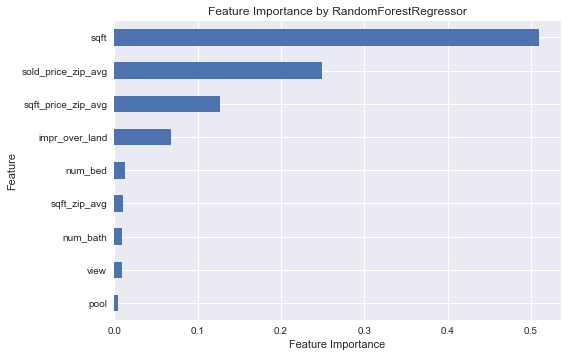

In [21]:
mm.plot_feature_importance()

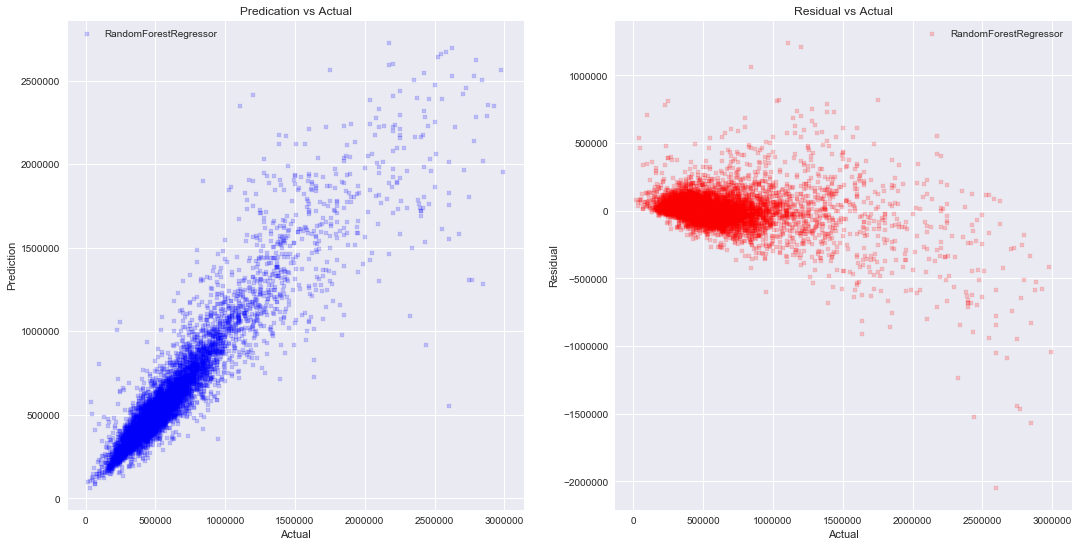

In [22]:
mm.plot_residual()

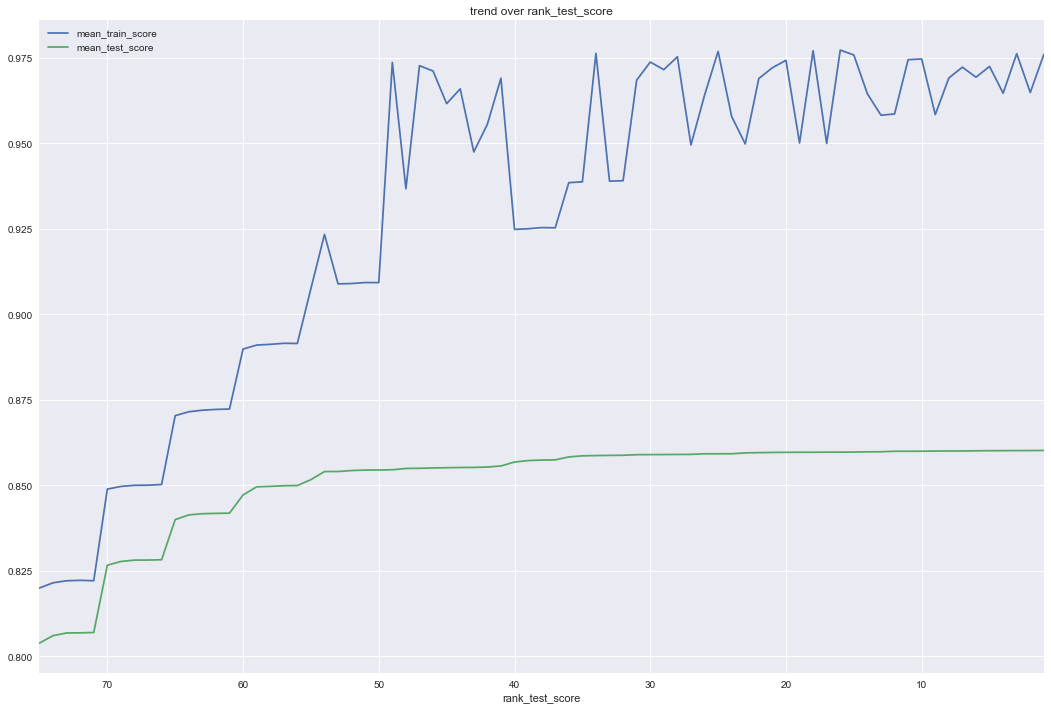

In [23]:
ranked_params = mm.plot_learning_curve()

In [27]:
ranked_params[:25]

[{'max_depth': 5, 'n_estimators': 20},
 {'max_depth': 5, 'n_estimators': 60},
 {'max_depth': 5, 'n_estimators': 180},
 {'max_depth': 5, 'n_estimators': 140},
 {'max_depth': 5, 'n_estimators': 100},
 {'max_depth': 6, 'n_estimators': 20},
 {'max_depth': 6, 'n_estimators': 60},
 {'max_depth': 6, 'n_estimators': 100},
 {'max_depth': 6, 'n_estimators': 180},
 {'max_depth': 6, 'n_estimators': 140},
 {'max_depth': 7, 'n_estimators': 20},
 {'max_depth': 7, 'n_estimators': 60},
 {'max_depth': 7, 'n_estimators': 100},
 {'max_depth': 7, 'n_estimators': 180},
 {'max_depth': 7, 'n_estimators': 140},
 {'max_depth': 8, 'n_estimators': 20},
 {'max_depth': 8, 'n_estimators': 60},
 {'max_depth': 8, 'n_estimators': 100},
 {'max_depth': 8, 'n_estimators': 140},
 {'max_depth': 8, 'n_estimators': 180},
 {'max_depth': 9, 'n_estimators': 20},
 {'max_depth': 10, 'n_estimators': 20},
 {'max_depth': 9, 'n_estimators': 60},
 {'max_depth': 9, 'n_estimators': 100},
 {'max_depth': 9, 'n_estimators': 140}]